In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils

# Preprocess images, code from github https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

# This cell is meant to be run only once to preprocess the images and save them in a new folder
# You only need to run this cell once, after the folder has been created, you can ignore it

def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img
	

In [ ]:
# This cell is meant to be run only once to preprocess the images and save them in a new folder
# You only need to run this cell once, after the folder has been created, you can ignore it

training = "Training"
testing = "Testing"
training_dir = os.listdir(training)
testing_dir = os.listdir(testing)

IMG_SIZE = 64

# create training dirs
for dir in training_dir:
    save_path = 'cleaned/Training/'+ dir
    path = os.path.join(training,dir)
    image_dir = os.listdir(path)
    for img in image_dir:
        image = cv2.imread(os.path.join(path,img))
        new_img = crop_img(image)
        new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(save_path+'/'+img, new_img)

# create testing dirs
for dir in testing_dir:
    save_path = 'cleaned/Testing/'+ dir
    path = os.path.join(testing,dir)
    image_dir = os.listdir(path)
    for img in image_dir:
        image = cv2.imread(os.path.join(path,img))
        new_img = crop_img(image)
        new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(save_path+'/'+img, new_img)

Compare the image before and after processing

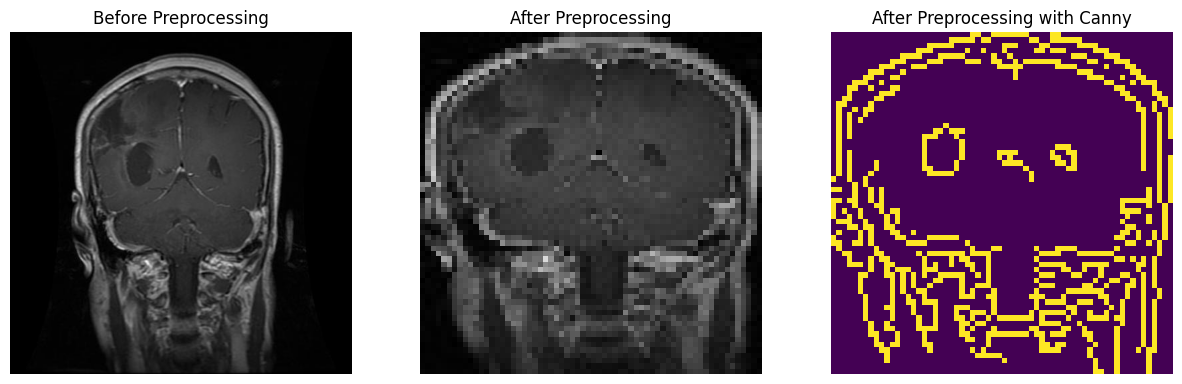

In [ ]:
import matplotlib.pyplot as plt

before = cv2.imread("Training/glioma/Tr-gl_0010.jpg")
after = cv2.imread("cleaned/Training/glioma/Tr-gl_0010.jpg")


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(before)
plt.title('Before Preprocessing')
plt.axis('off')


plt.subplot(132)
plt.imshow(after)
plt.title('After Preprocessing')
plt.axis('off')


## Training and testing with different methods

In [1]:
from sklearn.datasets import load_files
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
import mnist
import os
import cv2
import numpy as np

IMG_SIZE = 64

def super_simple_load(data_dir, img_size=(IMG_SIZE, IMG_SIZE)):
    X, y = [], []
    
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if not os.path.isdir(folder_path):
            continue
            
        # each label is assigned a numeric value
        label = len(set(y))
        
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path, 0)  # Grayscale
                img = cv2.resize(img, img_size).flatten() / 255.0
                
                X.append(img)
                y.append(label)
    
    return np.array(X), np.array(y)

In [2]:
from sklearn.model_selection import train_test_split

# load the data and split them into train, validation and test sets
X_train_full, y_train_full = super_simple_load("training/")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=20,
    stratify=y_train_full
)
X_test, y_test = super_simple_load("testing/")



In [ ]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

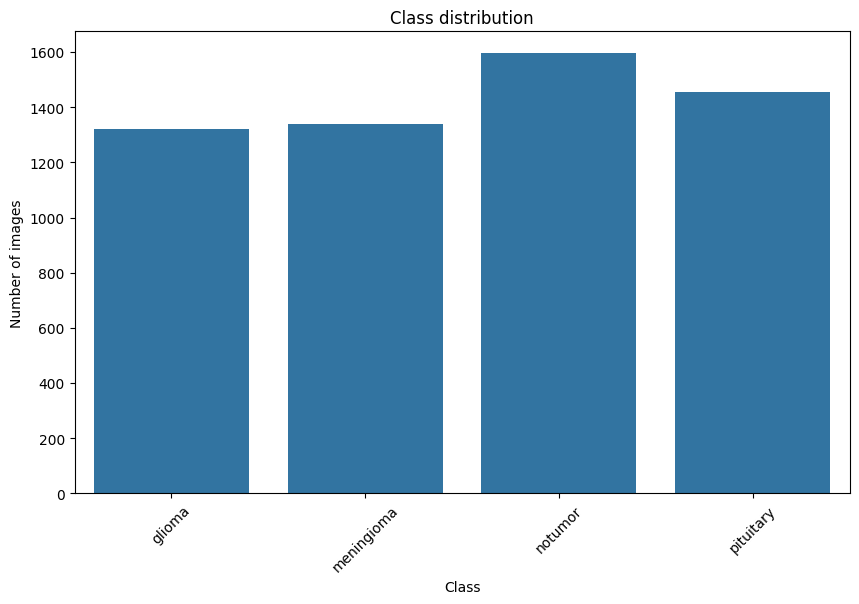

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize class distribution
classes = ["glioma", "meningioma", "notumor", "pituitary"]
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_full)
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.xticks(range(len(classes)), classes, rotation=45)
plt.show()


### Logistic Regression

C:\Users\danit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Log loss: 0.3930073073189831
Validation Log loss: 0.4265933307096573
Training accuracy: 0.9995622674545852
Validation accuracy: 0.8713910761154856
Test accuracy: 0.88558352402746


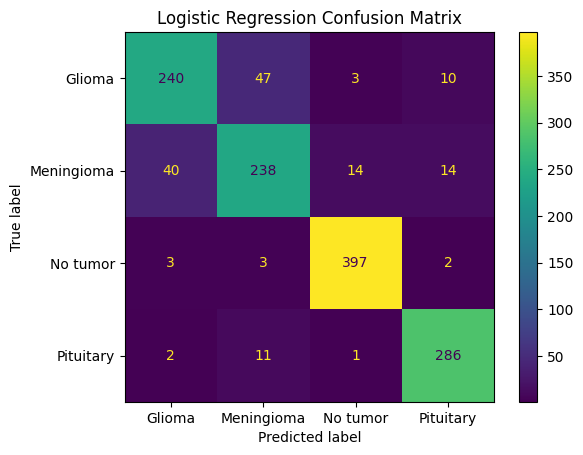

In [18]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_train, y_train)

# Get probability predictions instead of class predictions for log_loss
y_pred_proba = model.predict_proba(X_test)
test_loss = log_loss(y_test, y_pred_proba)
val_loss = log_loss(y_val, model.predict_proba(X_val))

train_accuracy = model.score(X_train, y_train)
val_accuracy = model.score(X_val, y_val)
test_accuracy = model.score(X_test, y_test)

print(f"Log loss: {test_loss}")
print(f"Validation Log loss: {val_loss}")
print(f"Training accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")
print(f"Test accuracy: {test_accuracy}")

# Also create confusion matrix for visualization
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Glioma", "Meningioma", "No tumor", "Pituitary"])
disp.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()



### CNN with keras

Epoch 1/30


C:\Users\danit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\danit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.4618 - loss: 1.1252 - val_accuracy: 0.6080 - val_loss: 0.9641
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 0.7065 - loss: 0.7536 - val_accuracy: 0.7795 - val_loss: 0.5731
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.7663 - loss: 0.5852 - val_accuracy: 0.7892 - val_loss: 0.5130
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.8214 - loss: 0.4756 - val_accuracy: 0.8600 - val_loss: 0.3710
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - accuracy: 0.8457 - loss: 0.4159 - val_accuracy: 0.8696 - val_loss: 0.3311
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 240ms/step - accuracy: 0.8639 - loss: 0.3630 - val_accuracy: 0.8889 - val_loss: 0.2861
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - accuracy: 0.8851 - loss: 0.3150 - val_accuracy: 0.9038 - val_loss: 0.2647
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 264ms/step - accuracy: 0.8949 - loss: 0.2794 - val_

<Figure size 800x600 with 0 Axes>

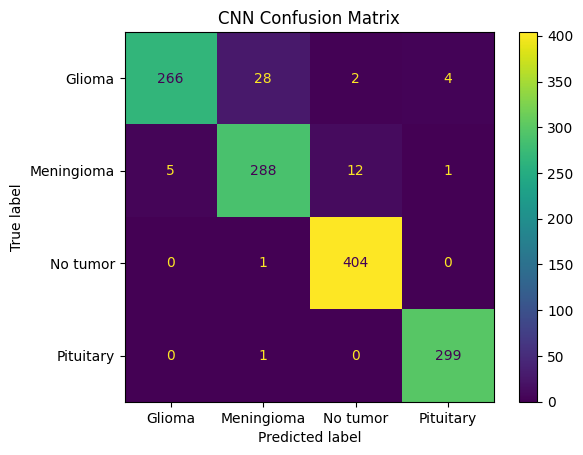


CNN Classification Report:
              precision    recall  f1-score   support

      Glioma       0.98      0.89      0.93       300
  Meningioma       0.91      0.94      0.92       306
    No tumor       0.97      1.00      0.98       405
   Pituitary       0.98      1.00      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



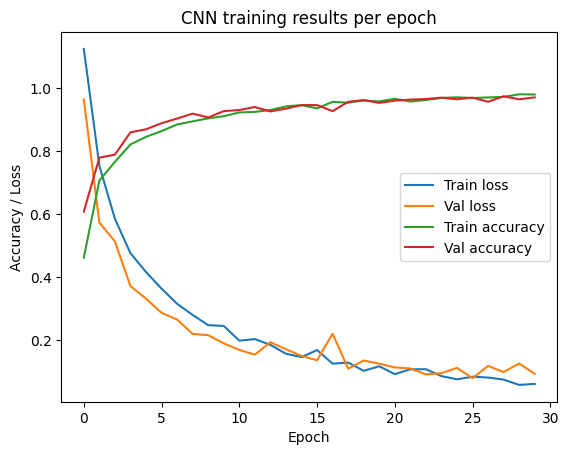

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X_train_new = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val_new = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test_new = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

datagen = ImageDataGenerator(
    horizontal_flip=True 
    )

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(128, (3,3), activation='relu'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    datagen.flow(X_train_new, to_categorical(y_train, num_classes=4), batch_size=32),
    epochs=30,
    validation_data=(X_val_new, to_categorical(y_val, num_classes=4)),
)

model.evaluate(X_test_new, to_categorical(y_test, num_classes=4))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test_new)
y_pred = np.argmax(y_pred_proba, axis=1)

conf_mat = confusion_matrix(y_test, y_pred)
class_names = ["Glioma", "Meningioma", "No tumor", "Pituitary"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot()
plt.title('CNN Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report
print("\nCNN Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy / Loss")
plt.title("CNN training results per epoch")
plt.legend()
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


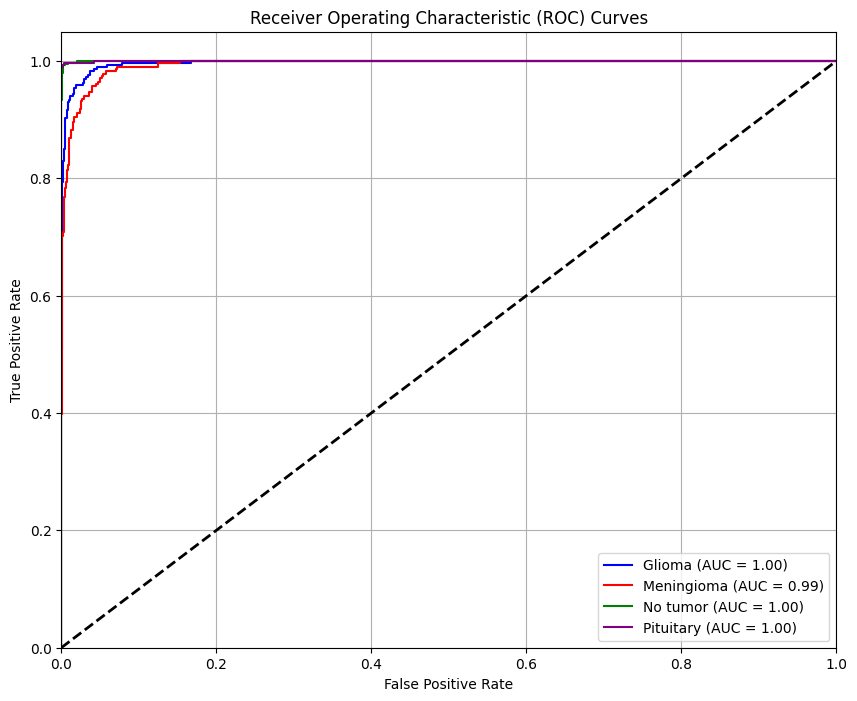


AUC scores for each class:
Glioma: 0.9966
Meningioma: 0.9935
No tumor: 0.9998
Pituitary: 0.9998


In [29]:
from sklearn.metrics import roc_curve, auc

# Get predictions probabilities for test set
y_pred_proba = model.predict(X_test_new)

# Initialize lists to store FPR, TPR and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Calculate ROC curve and ROC area for each class
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_test)[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple']
classes = ["Glioma", "Meningioma", "No tumor", "Pituitary"]

for i, color, cls in zip(range(4), colors, classes):
    plt.plot(
        fpr[i], 
        tpr[i], 
        color=color,
        label=f'{cls} (AUC = {roc_auc[i]:.2f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC scores
print("\nAUC scores for each class:")
for i, cls in enumerate(classes):
    print(f"{cls}: {roc_auc[i]:.4f}")